# Use PARP1 model to predict on PARP1 dataset

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()

import pandas as pd
import sys
import umap

from rdkit import Chem
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse
import atomsci.ddm.utils.struct_utils as struct_utils
import atomsci.ddm.pipeline.model_tracker as mt
import atomsci.ddm.pipeline.chem_diversity as cd
import atomsci.ddm.pipeline.predict_from_model as pfm
import atomsci.ddm.pipeline.featurization as feat
import atomsci.ddm.pipeline.diversity_plots as dp

import warnings
warnings.filterwarnings(action='once')
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score, precision_recall_curve, average_precision_score, confusion_matrix

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 90)


# load data
- Here, load the data with smiles you want to predict on. 
- If the smiles are not standardized, uncomment the base_rdkit_smiles line

In [2]:
pred_data_path = "~/atom/PARP_compounds/Datasets_and_Models/Otava_library/otava_csv.csv"
df=pd.read_csv(pred_data_path)
# df['base_rdkit_smiles']=df['smiles'].apply(struct_utils.base_smiles_from_smiles)
df

,compound_id,mol weight structure,nHD,nHA,nRB,CLogP,nRings,PSA,Name,Smiles,InChI Key,Saltdata,base_rdkit_smiles,mol_wt
0,P0103550109,392.33475,1,5,3,4.5,4,65.0,"3-(2,3-dihydro-1,4-benzodioxin-6-yl)-6-ethyl-7...",CCc1cc2C(=O)C(=C(Oc2cc1O)C(F)(F)F)c3ccc4OCCOc4c3,MPHUZEMMOJKBQT-UHFFFAOYSA-N,NaN,CCc1cc2c(=O)c(-c3ccc4c(c3)OCCO4)c(C(F)(F)F)oc2...,392.087158
1,P0103580021,386.33341,1,4,3,4.5,4,64.4,7-hydroxy-5-methyl-3-(1-phenylpyrazol-4-yl)-2-...,Cc1cc(O)cc2OC(=C(C(=O)c12)c3cnn(c3)c4ccccc4)C(...,AICWQXZGHCIEFC-UHFFFAOYSA-N,NaN,Cc1cc(O)cc2oc(C(F)(F)F)c(-c3cnn(-c4ccccc4)c3)c...,386.087827
2,P0103960014,279.31963,0,3,1,3.9,4,67.4,"3-(1,3-benzothiazol-2-yl)chromen-2-one",O=C1Oc2ccccc2C=C1c3nc4ccccc4s3,KMZRPGPWSFZJLB-UHFFFAOYSA-N,NaN,O=c1oc2ccccc2cc1-c1nc2ccccc2s1,279.035400
3,P0104650004,314.35248,2,5,2,3.8,4,92.6,"2-amino-1-(3-methylanilino)pyrrolo[3,2-b]quino...",Cc1cccc(Nn2c(N)c(C#N)c3nc4ccccc4nc23)c1,SBTUDJZPSYMHOQ-UHFFFAOYSA-N,NaN,Cc1cccc(Nn2c(N)c(C#N)c3nc4ccccc4nc32)c1,314.127994
4,P0105990013,359.40389,0,6,6,2.5,3,103.0,ethyl 2-[5-methyl-3-(4-methylthiazol-2-yl)-4-o...,CCOC(=O)COc1cc(C)c2C(=O)C(=COc2c1)c3nc(C)cs3,PEVDHGMJFRLHBT-UHFFFAOYSA-N,NaN,CCOC(=O)COc1cc(C)c2c(=O)c(-c3nc(C)cs3)coc2c1,359.082744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,P7714290134,294.31558,2,5,4,2.5,3,75.1,"6-methyl-5-(4-phenoxyanilino)-2H-1,2,4-triazin...",CC1=NNC(=O)N=C1Nc2ccc(Oc3ccccc3)cc2,MBUCBXKFAOLQAF-UHFFFAOYSA-N,NaN,Cc1n[nH]c(=O)nc1Nc1ccc(Oc2ccccc2)cc1,294.111676
452,P7714290148,302.33571,2,6,6,2.0,2,92.2,"isobutyl 4-[(6-methyl-3-oxo-2H-1,2,4-triazin-5...",CC(C)COC(=O)c1ccc(NC2=NC(=O)NN=C2C)cc1,HWBWRXRNFXSYQR-UHFFFAOYSA-N,NaN,Cc1n[nH]c(=O)nc1Nc1ccc(C(=O)OCC(C)C)cc1,302.137890
453,P7720190004,382.44431,2,5,7,2.2,3,116.2,"N,N-dibenzyl-2-[(3,5-dioxo-2H-1,2,4-triazin-6-...",O=C(CSC1=NNC(=O)NC1=O)N(Cc2ccccc2)Cc3ccccc3,HVWJTOURFVGIRF-UHFFFAOYSA-N,NaN,O=C(CSc1n[nH]c(=O)[nH]c1=O)N(Cc1ccccc1)Cc1ccccc1,382.109961
454,P980926,378.34153,0,7,5,3.1,4,88.1,methyl 2-[2-oxo-4-(2-oxochromen-3-yl)chromen-7...,COC(=O)COc1ccc2C(=CC(=O)Oc2c1)C3=Cc4ccccc4OC3=O,JVXHQJDMILOHCC-UHFFFAOYSA-N,NaN,COC(=O)COc1ccc2c(-c3cc4ccccc4oc3=O)cc(=O)oc2c1,378.073953


## Featurize

Since the PARP1 model is a graph convolutional neural network, you do not need to featurize. I kept this code here for completeness.

In [3]:
# params = {
#     # general
#     "hyperparam": "True",
#     "lc_account": "asccasc",
#     "slurm_partition": "pbatch",
#     "uncertainty": "True",
#     "search_type": "user_specified",
#     "save_results": "True",
#     "verbose": "True",
#     "script_dir": "/g/g16/apaulson/github_repos/AMPL/atomsci/ddm",
#     "python_path": "/g/g16/apaulson/miniconda3/envs/ampl-120/bin/python",
#     "system": "LC",
#     "rerun": "False",
    
#     # dataset info
#     "dataset_key" : "/g/g16/apaulson/atom/PARP_compounds/Datasets_and_Models/Otava_library/otava_csv.csv",
#     "datastore": "False",
#     "response_cols" : 'mol_wt',
#     "num_model_tasks" : "1",
#     "id_col": "compound_id",
#     "smiles_col" : "base_rdkit_smiles",
#     "result_dir": f'/g/g16/apaulson/atom/PARP_compounds/Datasets_and_Models/Otava_library/',

#     # splitting
#     "split_only": "True",
#     "previously_split": "False",
#     "splitter": "random",
#     "split_valid_frac": "0.1",
#     "split_test_frac": "0.1",

#     # featurization & training params
#     "prediction_type": "regression",
#     "transformers": "True",
# #     "featurizer": "computed_descriptors",
# #     "descriptor_type": "rdkit_raw",
#     "featurizer": "computed_descriptors",
#     "descriptor_type": "moe", # for featurizer = computed descriptors
#     "model_type": "RF"
# }

# # for descr in ['rdkit_raw','mordred_filtered','moe']:
# #     params['descriptor_type']=descr
# #     # dataset csv file needs to not have an unnamed first column in order to 
# #     # compute moe descriptors for some reason /shrug
# #     # naming it index works, naming it idx messes up the id columns
# #     # name it manually before running this
# #     pparams = parse.wrapper(params)
# #     MP = mp.ModelPipeline(pparams)
# #     featurization=None
# #     # comment out this line after splitting once so you don't re-split
# #     MP.run_mode = 'training'
# #     MP.params.split_only = True
# #     MP.params.previously_split = False
# #     if featurization is None:
# #         featurization = feat.create_featurization(MP.params)
# #     MP.featurization = featurization
# #     MP.load_featurize_data()

In [4]:
# params['featurizer']='ecfp'
# params['response_cols'] = 'mol_wt'
# pparams = parse.wrapper(params)
# MP = mp.ModelPipeline(pparams)
# featurization=None
# MP.run_mode = 'training'
# MP.params.split_only = True
# MP.params.previously_split = False
# if featurization is None:
#     featurization = feat.create_featurization(MP.params)
# MP.featurization = featurization
# MP.load_featurize_data()

In [5]:
# ecfp = pd.DataFrame(MP.data.dataset.X)
# ecfp.columns = ['ecfp_'+str(col) for col in ecfp.columns]
# df['source'] = 'Otava'

In [6]:
# ecfp_df = pd.concat([df[['compound_id', 'base_rdkit_smiles', 'source']], ecfp], axis=1)
# ecfp_df.to_csv("~/atom/PARP_compounds/Datasets_and_Models/Otava_library/scaled_descriptors/otava_csv_with_ecfp_descriptors.csv", index=False)

## Predict
This section is set up to loop through several models in a list but I've only included the PARP1 model here.

In [6]:
# define the original training data for the model here. It gets passed to the prediction function via external_training_dataset
p1_training_data_path = 'PARP1_gostar_2022-06-20_chembl_30_gostar_custom_2022-06-23_UCSF_pIC50_agg.csv'
extdatas=[p1_training_data_path]

In [7]:
# define model path(s) and other variables for prediction function
p1_path = "PARP1_CGUAgg_2022-06_fingerprint_graphconv_model_4f296899-1e4f-4d08-a7c5-47ef64d7fec3.tar.gz"
paths=[p1_path]
models=['PARP1_pXC50']
feats = ['graphconv']

In [8]:
df=pd.read_csv(p1_training_data_path)
for modpath, modtype, feattype, extdata in zip(paths, models, feats, extdatas):
    # define model
    model_path = modpath
    
    # if computed descriptors are used, open them here from scaled_descriptors folder and use this as input data
    if feattype not in ['ecfp', 'graphconv']:
        feat_data_path = f"~/atom/PARP_compounds/Datasets_and_Models/PARP1/scaled_descriptors/PARP1_gostar_2022-06-20_chembl_30_gostar_custom_2022-06-23_UCSF_pIC50_agg_with_{feattype}_descriptors.csv"
        feat_data = pd.read_csv(feat_data_path)
        is_featurized=True
    # if ecfp or graphconv, you don't need the computed descriptor file
    else:
        feat_data=df
        is_featurized=False
    input_df = feat_data
    
    # here
    id_col = 'compound_id'
    smiles_col = 'base_rdkit_smiles'
    response_col = 'activity_value'
    dont_standardize = True # smiles have already been standardized
    AD_method = 'z_score'

    pred_df = pfm.predict_from_model_file(model_path = model_path, input_df=input_df, id_col=id_col, smiles_col=smiles_col, response_col=response_col,
                                dont_standardize=dont_standardize, is_featurized = is_featurized, AD_method=AD_method, external_training_data=extdata)

    pred_df.to_csv(f"./2022_12_22_Otava_pred_{modtype}.csv", index=False)

INFO:atomsci.ddm.utils.model_version_utils:PARP1_CGUAgg_2022-06_fingerprint_graphconv_model_4f296899-1e4f-4d08-a7c5-47ef64d7fec3.tar.gz, 1.4.2
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: PARP1_CGUAgg_2022-06_fingerprint_graphconv_model_4f296899-1e4f-4d08-a7c5-47ef64d7fec3.tar.gz version = "1.4.2", AMPL version = "1.4.2"


num_model_tasks is deprecated and its value is ignored.
Featurization = DynamicFeaturization with graphconv features
number of features: 75


In [9]:
pred_df

,compound_id,base_rdkit_smiles,relation,activity_value,activity_value_actual,activity_value_pred
0,gvk_121938715,Cc1cc2c(=O)[nH]c(-c3cnn(C(C)(C)C)c3)cn2c1,NaN,6.522879,6.522879,4.859187
1,gvk_122322701,CC(C)(O)c1ccc(-c2nn3cc(Cl)cc3c(=O)[nH]2)cc1,NaN,5.522879,5.522879,5.090549
2,Otava_1084099,Cc1oc2ccc(O)cc2c1C(=O)Nc1cc(Cl)ccc1Cl,NaN,4.444000,4.444000,5.353268
3,gvk_125398920,COc1cc(C=C2C(=O)N(C)C(=O)N(C)C2=O)cc(CN2CCOCC2...,NaN,7.381638,7.381638,6.010265
4,gvk_125378925,O=c1cc(-c2ccc(O)cc2)oc2c(CN3CCN(c4ccc(O)cc4)CC...,NaN,7.401209,7.401209,6.531475
...,...,...,...,...,...,...
9406,gvk_3823972,O=c1[nH]nc(CCCCN2CC=C(c3ccc(F)cc3)CC2)c2ccccc12,NaN,7.309804,7.309804,6.706161
9407,gvk_15323173,O=C(c1cccc(CCl)c1)N1CCc2c([nH]c(=O)c3ccccc23)C1,NaN,6.097453,6.097453,5.635303
9408,gvk_15327451,CCc1cc(-c2ccc(CNCc3cnn(C)c3)o2)c(C)[nH]c1=O,NaN,6.522879,6.522879,5.626771
9409,gvk_125440805,O=C1N(c2cncc(Cc3n[nH]c(=O)c4ccccc34)c2)c2ccccc...,>,8.000000,8.000000,6.922460


In [11]:
# rename columns in pred_df for clarity and merge with original prediction data df
# this is useful if you have more than one set of model predictions to merge together
df=pd.read_csv(pred_data_path)
for modtype in models:
    pred_df=pd.read_csv(f"./2022_12_22_Otava_pred_{modtype}.csv")
    columns=[]
    for col in pred_df.columns:
        colname=col
        if '_pred' in col:
            colname=f'{modtype}_pred'
        if '_prob' in col:
            colname=f'{modtype}_prob'
        if '_std' in col:
            colname=f'{modtype}_std'
        if 'AD_index' in col:
            colname=f'{modtype}_adi'
        columns.append(colname)
    pred_df.columns=columns
    # merge on all shared columns
    df=df.merge(pred_df)
df.to_csv("./2022_12_22_Otava_csv_predictions.csv")

# visualize predictions

In [12]:
# here, merge the original training data with your new predicted data

df=pd.read_csv("./2022_12_22_Otava_csv_predictions.csv", index_col=0)

p1=pd.read_csv(p1_training_data_path, index_col=0)

df=df.merge(p1, how='left')

df.head()

,compound_id,mol weight structure,nHD,nHA,nRB,CLogP,nRings,PSA,Name,Smiles,InChI Key,Saltdata,base_rdkit_smiles,mol_wt,PARP1_pXC50_pred,relation,activity_value
0,P0103550109,392.33475,1,5,3,4.5,4,65.0,"3-(2,3-dihydro-1,4-benzodioxin-6-yl)-6-ethyl-7...",CCc1cc2C(=O)C(=C(Oc2cc1O)C(F)(F)F)c3ccc4OCCOc4c3,MPHUZEMMOJKBQT-UHFFFAOYSA-N,NaN,CCc1cc2c(=O)c(-c3ccc4c(c3)OCCO4)c(C(F)(F)F)oc2...,392.087158,4.846554,NaN,NaN
1,P0103580021,386.33341,1,4,3,4.5,4,64.4,7-hydroxy-5-methyl-3-(1-phenylpyrazol-4-yl)-2-...,Cc1cc(O)cc2OC(=C(C(=O)c12)c3cnn(c3)c4ccccc4)C(...,AICWQXZGHCIEFC-UHFFFAOYSA-N,NaN,Cc1cc(O)cc2oc(C(F)(F)F)c(-c3cnn(-c4ccccc4)c3)c...,386.087827,4.567693,<,3.400117
2,P0103960014,279.31963,0,3,1,3.9,4,67.4,"3-(1,3-benzothiazol-2-yl)chromen-2-one",O=C1Oc2ccccc2C=C1c3nc4ccccc4s3,KMZRPGPWSFZJLB-UHFFFAOYSA-N,NaN,O=c1oc2ccccc2cc1-c1nc2ccccc2s1,279.035400,3.558011,NaN,5.855000
3,P0104650004,314.35248,2,5,2,3.8,4,92.6,"2-amino-1-(3-methylanilino)pyrrolo[3,2-b]quino...",Cc1cccc(Nn2c(N)c(C#N)c3nc4ccccc4nc23)c1,SBTUDJZPSYMHOQ-UHFFFAOYSA-N,NaN,Cc1cccc(Nn2c(N)c(C#N)c3nc4ccccc4nc32)c1,314.127994,3.913817,<,3.400117
4,P0105990013,359.40389,0,6,6,2.5,3,103.0,ethyl 2-[5-methyl-3-(4-methylthiazol-2-yl)-4-o...,CCOC(=O)COc1cc(C)c2C(=O)C(=COc2c1)c3nc(C)cs3,PEVDHGMJFRLHBT-UHFFFAOYSA-N,NaN,CCOC(=O)COc1cc(C)c2c(=O)c(-c3nc(C)cs3)coc2c1,359.082744,4.753809,<,3.400117


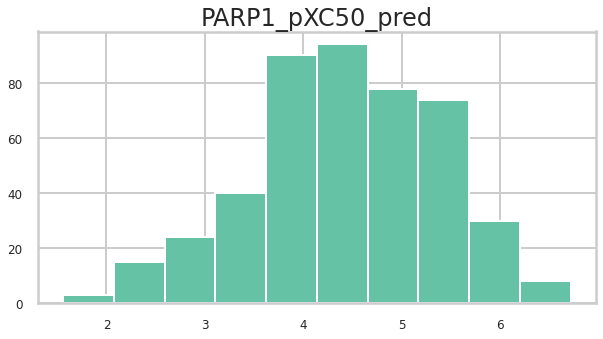

In [13]:
# visualize data
df.hist(column=[col for col in df.columns if ('_pred' in col) or ('_prob' in col)], figsize=(10,5));

<AxesSubplot:xlabel='PARP1_pXC50_pred', ylabel='activity_value'>

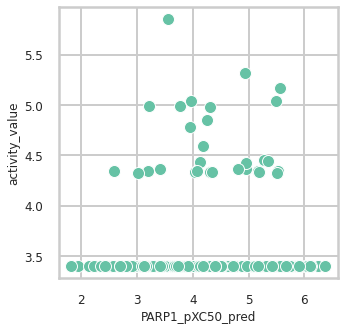

In [14]:
# plot real vs actual - this will only work if you have real values 
# from the training data and predicted values for the same compounds
fig, ax = plt.subplots(1,1,sharex=True, sharey=True, figsize=(5,5))
sns.scatterplot(ax=ax, data=df, y='activity_value', x='PARP1_pXC50_pred')

In [15]:
# # plot data shaded by ADI (not applicable for graph conv models)

# fig, ax = plt.subplots(1,1,sharex=True, sharey=False, figsize=(10,10))
# sns.scatterplot(ax=ax[0], data=df, y='PARP1_pXC50_pred', x='pIC50_PARP1', hue='PARP1_pXC50_new_adi', legend=True)
# # ax[0].set_xlim(3,9)
# # ax[0].set_ylim(3,9)
# # ax[1].set_ylim(3,9)
# fig.tight_layout()

In [16]:
# fig, ax = plt.subplots(1,2,sharex=True, sharey=False, figsize=(20,10))
# sns.scatterplot(ax=ax[0], data=df[df.hitc_PARP1==1], y='PARP1_pXC50_new_pred', x='pIC50_PARP1', hue='PARP1_pXC50_new_adi', legend=False)
# sns.scatterplot(ax=ax[1], data=df[df.hitc_PARP2==1], y='PARP2_pXC50_new_pred', x='pIC50_PARP2', hue='PARP2_pXC50_new_adi', legend=True)
# ax[0].set_xlim(3,9)
# ax[0].set_ylim(3,9)
# ax[1].set_ylim(3,9)
# fig.tight_layout()

# Visualize diversity of compounds

In [17]:
df.shape

(456, 17)

In [18]:
df.head(2)

,compound_id,mol weight structure,nHD,nHA,nRB,CLogP,nRings,PSA,Name,Smiles,InChI Key,Saltdata,base_rdkit_smiles,mol_wt,PARP1_pXC50_pred,relation,activity_value
0,P0103550109,392.33475,1,5,3,4.5,4,65.0,"3-(2,3-dihydro-1,4-benzodioxin-6-yl)-6-ethyl-7...",CCc1cc2C(=O)C(=C(Oc2cc1O)C(F)(F)F)c3ccc4OCCOc4c3,MPHUZEMMOJKBQT-UHFFFAOYSA-N,NaN,CCc1cc2c(=O)c(-c3ccc4c(c3)OCCO4)c(C(F)(F)F)oc2...,392.087158,4.846554,NaN,NaN
1,P0103580021,386.33341,1,4,3,4.5,4,64.4,7-hydroxy-5-methyl-3-(1-phenylpyrazol-4-yl)-2-...,Cc1cc(O)cc2OC(=C(C(=O)c12)c3cnn(c3)c4ccccc4)C(...,AICWQXZGHCIEFC-UHFFFAOYSA-N,NaN,Cc1cc(O)cc2oc(C(F)(F)F)c(-c3cnn(-c4ccccc4)c3)c...,386.087827,4.567693,<,3.400117


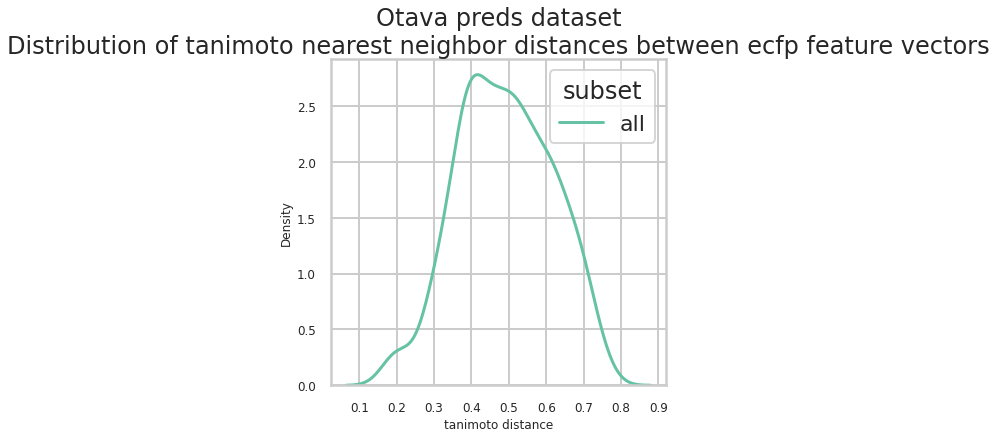

In [21]:
# plot distribution of tanimoto distances of each compound to its nearest neighbor
# higher values = more diverse compound set
dists=dp.plot_tani_dist_distr(df, 'base_rdkit_smiles', 'Otava preds', radius=4)

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/workspace/apaulson/miniconda3/envs/ampl-140/lib/python3.7/site-packages/umap/umap_.py:1504: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/g/g16/apaulson/github_repos/AMPL/atomsci/ddm/pipeline/diversity_plots.py:348: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')
/usr/workspace/apaulson/miniconda3/envs/ampl-140/lib/python3.7/site-packages/seaborn/matrix.py:308: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


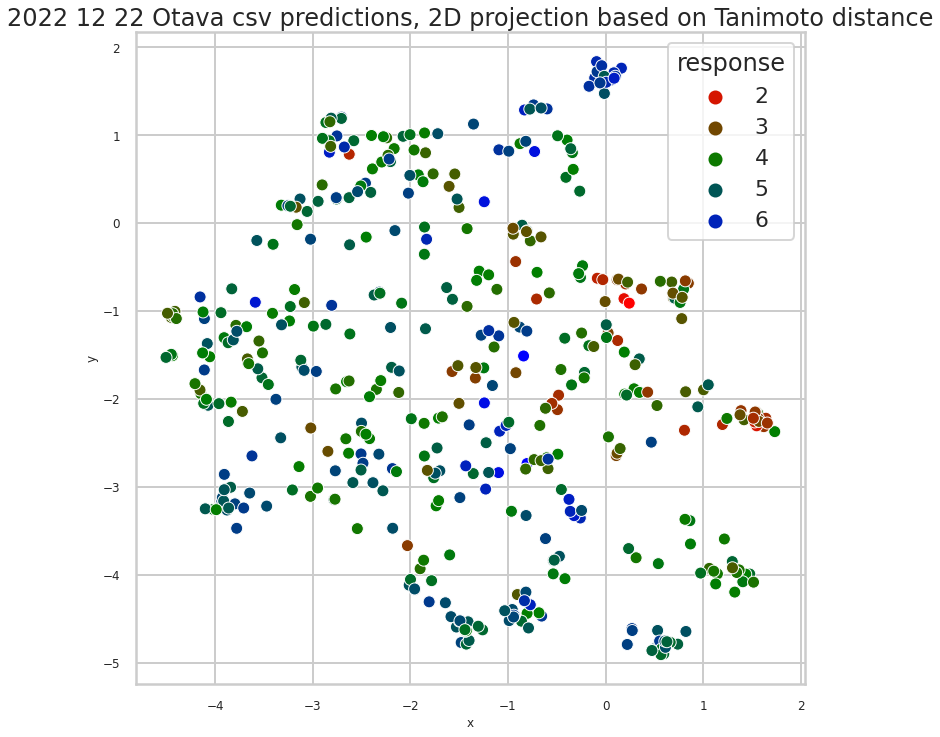

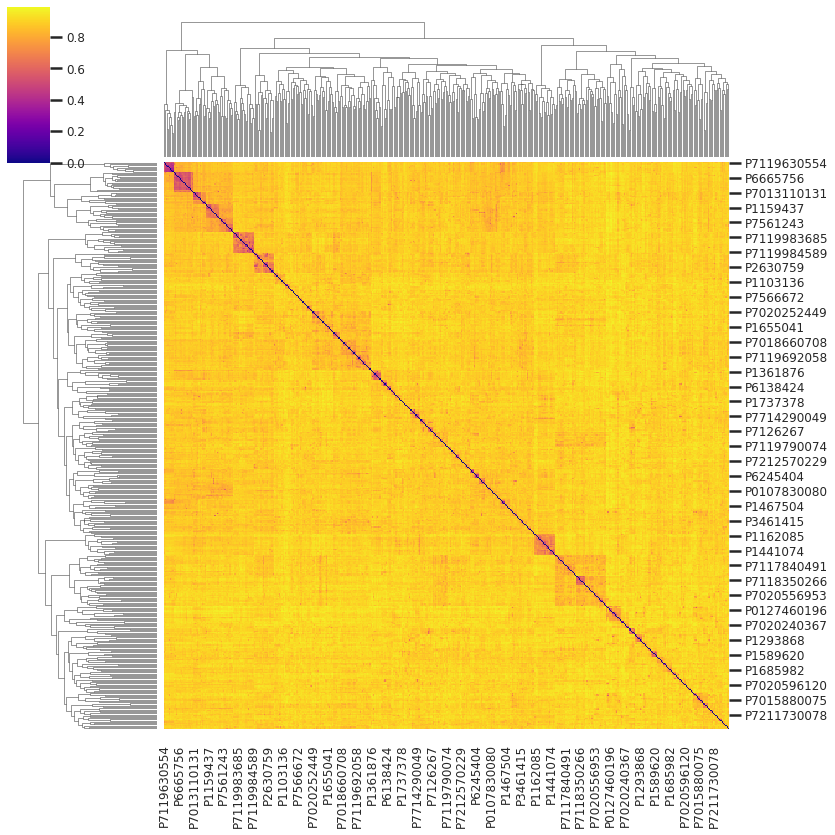

In [24]:
# diversity plots
dp.diversity_plots("./2022_12_22_Otava_csv_predictions.csv", datastore=False, 
                   smiles_col='base_rdkit_smiles', is_base_smiles=True,
                  response_col='PARP1_pXC50_pred')